In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from sys import stdout

In [1]:
ROOT_FOLDER = "../"
DATA_FOLDER = "data/processed/"

INPUT_LAB_SPEC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_train.csv"
INPUT_LAB_SPEC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_test.csv"

INPUT_LAB_CONC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_train.csv"
INPUT_LAB_CONC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_test.csv"

INPUT_AMB_SPEC = ROOT_FOLDER + DATA_FOLDER + "input_amb_spec.csv"
INPUT_AMB_CONC = ROOT_FOLDER + DATA_FOLDER + "input_amb_conc.csv"

# Loading the data

In [2]:
# Import Laboratory data

file_lab_spec_train = pd.read_csv(INPUT_LAB_SPEC_TRAIN, header=None)
file_lab_spec_test = pd.read_csv(INPUT_LAB_SPEC_TEST, header=None)
file_lab_conc_train = pd.read_csv(INPUT_LAB_CONC_TRAIN, header=None)
file_lab_conc_test = pd.read_csv(INPUT_LAB_CONC_TEST, header=None)

X_lab_train = pd.DataFrame(file_lab_spec_train).values.T
y_lab_train = pd.DataFrame(file_lab_conc_train).values.ravel()

X_lab_test = pd.DataFrame(file_lab_spec_test).values.T
y_lab_test = pd.DataFrame(file_lab_conc_test).values.ravel()

print("Train :\n")
print(X_lab_train.shape)
print(y_lab_train.shape)
print("\nTest :\n")
print(X_lab_test.shape)
print(y_lab_test.shape)

NameError: name 'pd' is not defined

In [4]:
# Import Ambient data

file_amb_spec = pd.read_csv(INPUT_AMB_SPEC, header=None)
file_amb_conc = pd.read_csv(INPUT_AMB_CONC, header=None)

X_amb = pd.DataFrame(file_amb_spec).values.T
y_amb = pd.DataFrame(file_amb_conc).values.ravel()



print(X_amb.shape)
print(y_amb.shape)

(2230, 2784)
(2230,)


In [5]:
"""

# Putting ambient and laboratory test sets together 
X_test = np.append(X_lab_test.T, X_amb_test.T, axis=0)
y_test = np.append(y_lab_test, y_amb_test, axis=0)

print(X_amb_test.T.shape)
print(X_lab_test.T.shape)

print(X_test.shape)
print(y_test.shape)
"""

'\n\n# Putting ambient and laboratory test sets together \nX_test = np.append(X_lab_test.T, X_amb_test.T, axis=0)\ny_test = np.append(y_lab_test, y_amb_test, axis=0)\n\nprint(X_amb_test.T.shape)\nprint(X_lab_test.T.shape)\n\nprint(X_test.shape)\nprint(y_test.shape)\n'

# Principal Component Analysis

## Part I : Build PCA model on laboratory standards

In [7]:
# Define PCA model
pca = PCA(n_components=144)
pca.fit(X_lab_train)
X_lab_train_pca = pca.transform(X_lab_train)
print(X_lab_train_pca.shape)

(144, 144)


In [20]:
clf = Lasso(alpha=1)
clf.fit(X_lab_train, y_lab_train)

y_lab_predict = clf.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

10.005963897978882


In [21]:
# define model PCA + Lasso
steps = [('pca', PCA(n_components=23)), ('m', Lasso())]
model = Pipeline(steps=steps)

# fit the model on the laboratory calibration dataset
model.fit(X_lab_train, y_lab_train)

# make a single prediction
y_lab_predict = model.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

#y_amb_predict = model.predict(X_amb_test)
#rmse_amb = np.sqrt(mean_squared_error(y_amb_predict, y_amb_test))
#print(rmse_amb)

4.511230575103683


In [13]:
def print_result(y_ref, y_pred, title):
    # Fit a line to the CV vs response
    z = np.polyfit(y_ref, y_pred, 1)
    plt.scatter(y_ref, y_pred, c='red')
    #Plot the best fit line
    plt.plot(y_ref, np.polyval(z, y_ref), c='green', linewidth=1)
    plt.plot(y_ref, y_ref, color='black', linewidth=1) # line y = x 
    plt.xlabel('Reference [$\mu$g/cm²]')
    plt.ylabel('Prediction [$\mu$g/cm²]')
    plt.title(title);

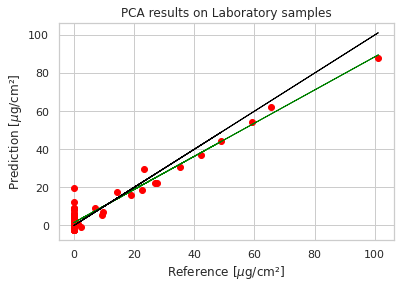

In [14]:
print_result(y_lab_test, y_predict, 'PCA results on Laboratory samples')

In [23]:
# make a prediction
y_predict = model.predict(X_amb_test.T)
rmse = np.sqrt(mean_squared_error(y_predict, y_amb_test))
rmse

1070.3218975150685

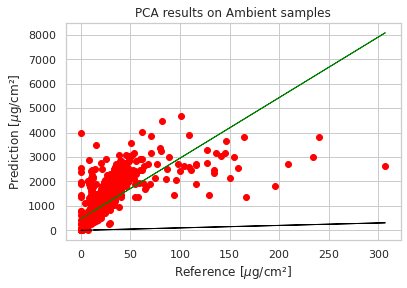

In [24]:
print_result(y_amb_test, y_predict, 'PCA results on Ambient samples')

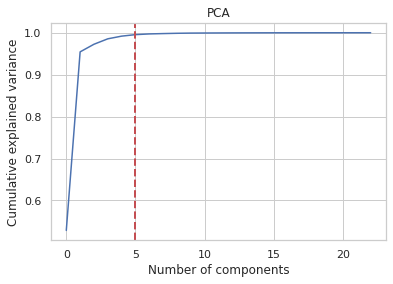

In [10]:
# Cumulative explained variance
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(linewidth=2, color='r', linestyle = '--', x=5, ymin=0, ymax=1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')
plt.show()